In [1]:
from __future__ import division
import numpy as np
import nibabel as nb
from ipywidgets import interact
from ipywidgets import widgets
import matplotlib.pyplot as plt
import scipy.ndimage
import tqdm
import glob
import os
%matplotlib inline

In [2]:
def plot_three(img, x, y, z, cmap=plt.cm.gray):
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(img[:, :, z]),
                        cmap=cmap,
                        interpolation='none'
                        )
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(img[:, y, :]),
                        cmap=cmap,
                        interpolation='none'
                        )
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(img[x, :, :]),
                        cmap=cmap,
                        interpolation='none'
              )

In [3]:
def show_image(path, x, y, z):
    img = nb.load(path).get_data()[..., 0]
    limits = (0, 2000)
    plot_three(img, x, y, z)
    mask = np.zeros_like(img, dtype=bool)
    mask[10:160, 120:190, 45:160] = 1
    img[~mask] = 0
    plot_three(img, x, y, z)
    segmentation_seed = np.zeros(img.shape, dtype=np.uint8)
    #segmentation_seed[img == 0] = 1
    #segmentation_seed[np.logical_and(img > 0, img < 300)] = 2
    segmentation_seed[np.logical_and(img > 650, img < 1000)] = 3
    segmentation_seed[np.logical_and(img > 1000, img < 1450)] = 4     
    plot_three(segmentation_seed, x, y, z)
    plt.figure()
    plt.hist(img[img > 0].flatten(), bins=256)
    plt.yscale('log', nonposy='clip')

(176, 208, 176)
(176, 208, 176)
(array([ 98,  98,  98, ..., 127, 127, 127]), array([ 87,  87,  88, ..., 105, 105, 106]), array([71, 72, 76, ..., 56, 57, 56]))
(98, 127, 82, 122, 43, 78)
(array([ 98,  98,  98, ..., 127, 127, 127]), array([ 87,  87,  88, ..., 105, 105, 106]), array([71, 72, 76, ..., 56, 57, 56]))


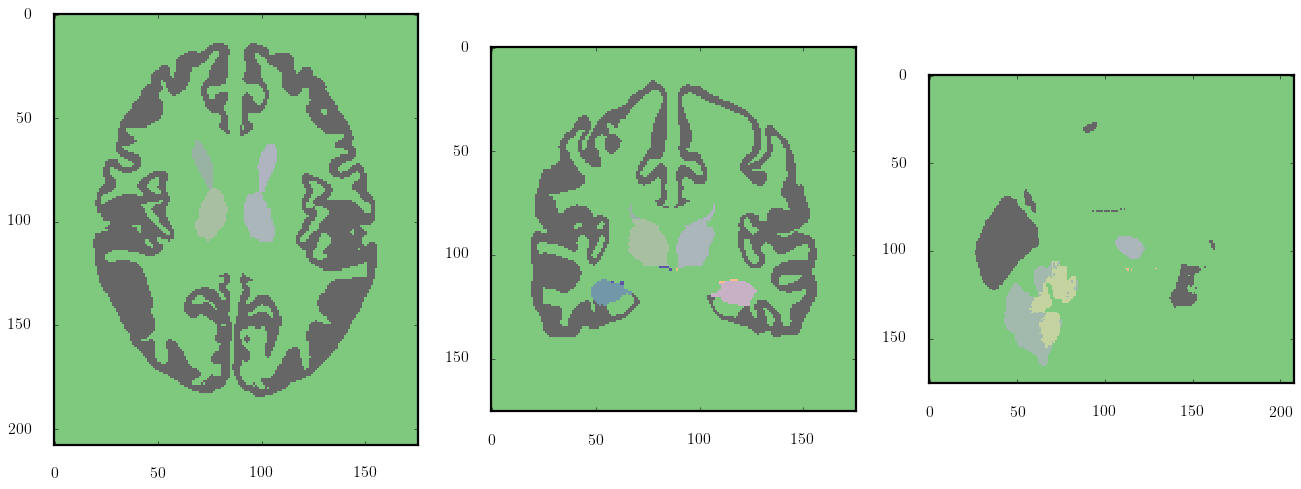

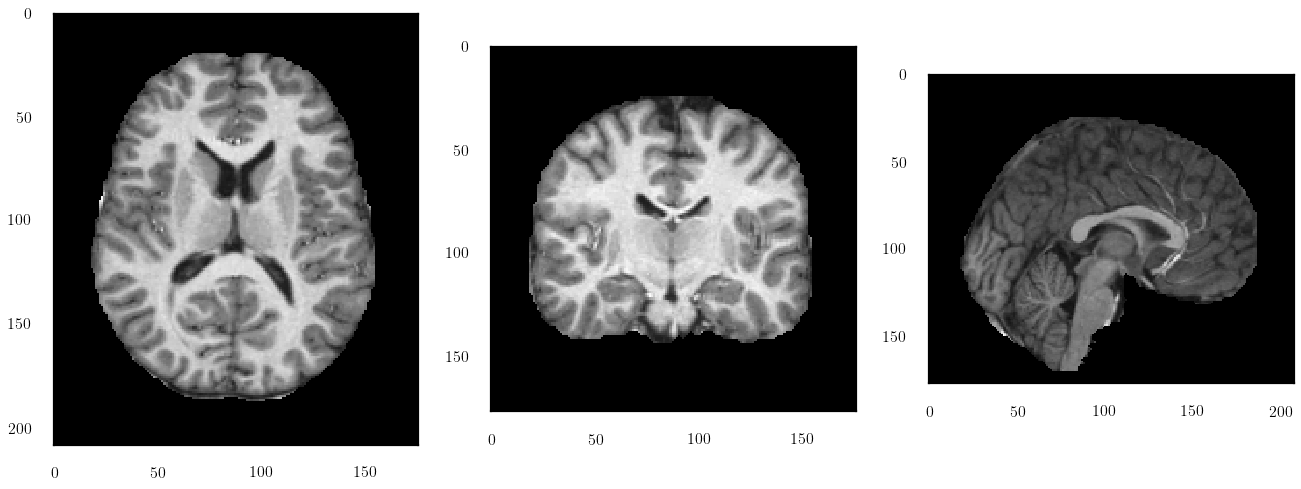

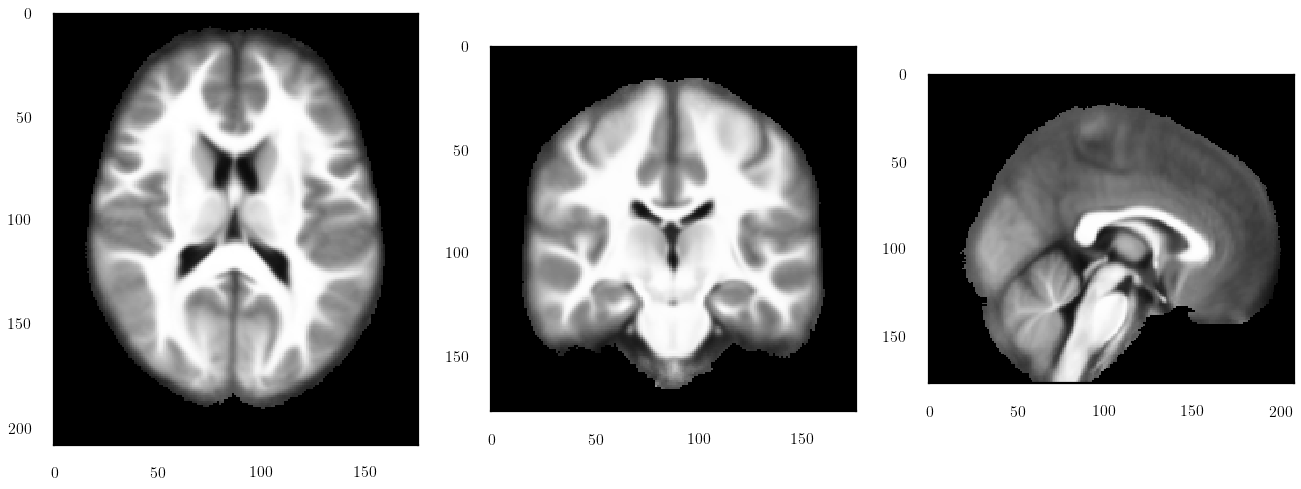

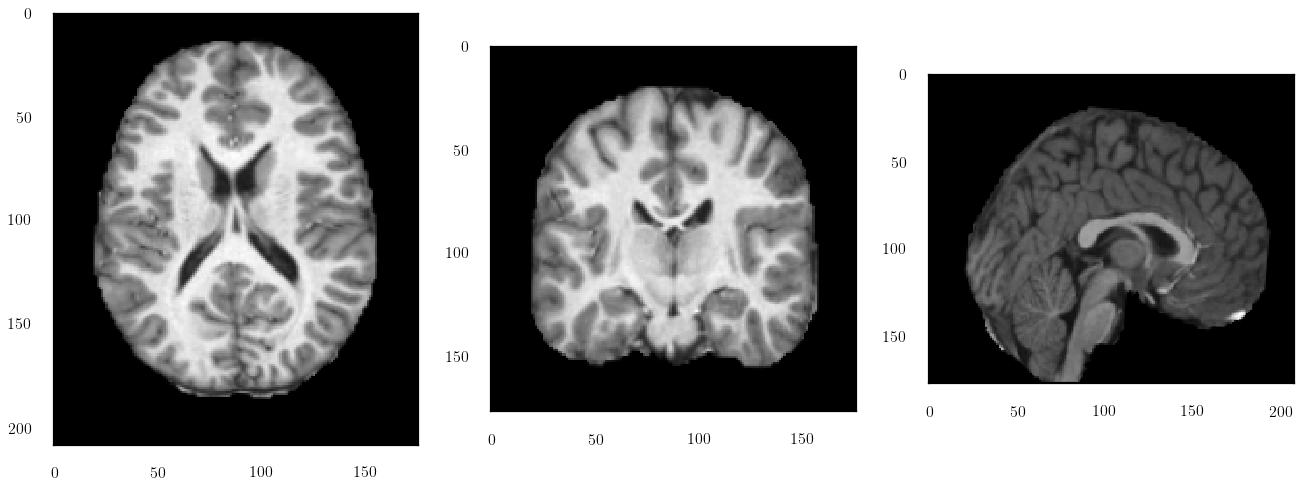

In [9]:
def show_atlas(path, x, y, z):
    atlas = nb.load("../data/IIT_GM_Desikan_atlas_cropped.nii.gz").get_data()
    mean_brain = nb.load("../data/IITmean_t1_cropped.nii.gz").get_data()
    print(atlas.shape)
    atlas[atlas > 60] = 100 # cortex = 100
    plot_three(atlas, x, y, z, cmap=plt.cm.Accent)
    img = nb.load(path).get_data()[..., 0]
    print(img.shape)
    plot_three(img, x, y, z)
    plot_three(mean_brain, x, y, z)
    flirt_output = nb.load("../data/train_1_flirt.nii.gz").get_data()
    plot_three(flirt_output, x, y, z)
    left_hippo = np.where(atlas == 17)
    print(left_hippo)
    x, y, z = np.where(atlas == 17)
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    z_min, z_max = np.min(z), np.max(z)
    print(x_min, x_max, y_min, y_max, z_min, z_max)
    print(x, y, z)



shape = (176, 208, 176)
path = widgets.Text("../data/set_train/train_1.nii")
interact(
    show_atlas,
    path=path,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
);

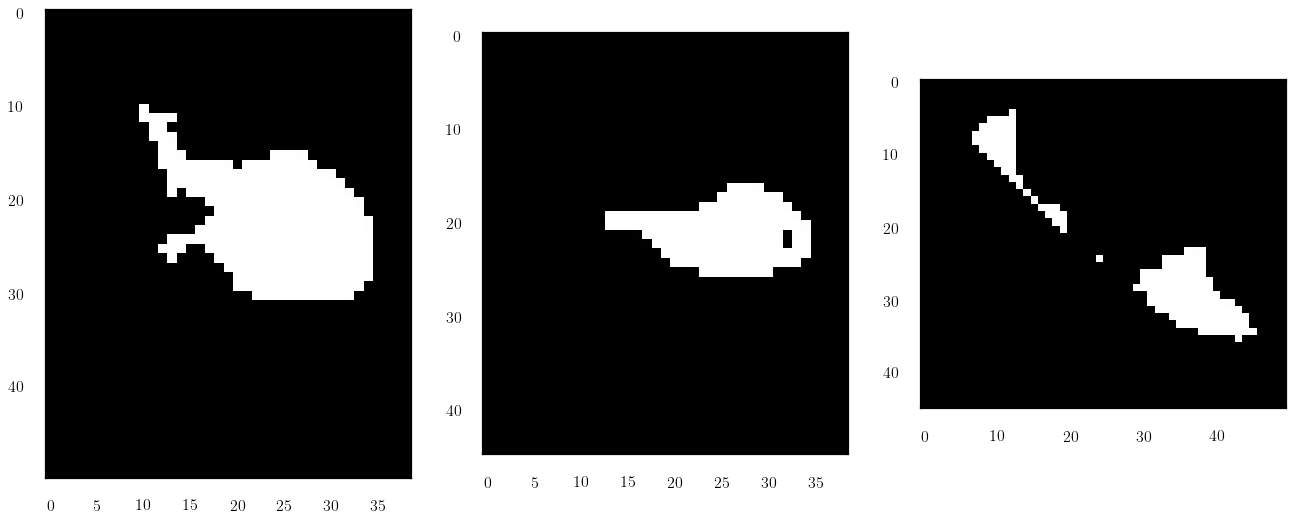

In [21]:
def extract_feature(desikan_label_id, file_name):
    atlas_name = "../data/IIT_GM_Desikan_atlas_cropped.nii.gz"
    atlas = nb.load(atlas_name).get_data()
    atlas[atlas != desikan_label_id] = 0
    mean_brain = nb.load("../data/IITmean_t1_cropped.nii.gz").get_data()
    x, y, z = np.where(atlas == desikan_label_id)
    x_min, x_max = np.min(x) - 5, np.max(x) + 5
    y_min, y_max = np.min(y) - 5, np.max(y) + 5
    z_min, z_max = np.min(z) - 5, np.max(z) + 5
    image = nb.load(file_name).get_data()[
        x_min:x_max, y_min:y_max, z_min:z_max]    
    plot_three(atlas[x_min:x_max, y_min:y_max, z_min:z_max], 12, 20, 20)
    

extract_feature(17, "../data/set_train/train_1.nii")
    

In [22]:
desikan_label_ids = {
    # "left_thalamus": 10,
    # "right_thalamus": 49,
    # "left_caudate": 11,
    # "right_caudate": 50,
    # "left_putamen": 12,
    # "right_putamen": 51,
    # "left_pallidum": 13,
    # "right_pallidum": 52,
    "left_hippocampus": 17,
    # "right_hippocampus": 53,
    # "left_amygdala": 18,
    # "right_amygdala": 54,
}

In [38]:
def show_alignment(input_file, i, j, k):
    basename = os.path.splitext(os.path.basename(input_file))[0]
    print(basename)
    output_dir = "../data/fsl/{0}".format(basename)
    omat = os.path.join(output_dir, basename) + ".mat"
    out = os.path.join(output_dir, basename) + "_flirt.nii.gz"
    # ref_name = "../data/IIT_GM_Desikan_atlas_cropped.nii.gz"
    ref_name = "../data/IITmean_t1_cropped.nii.gz"
    atlas_name = "../data/IIT_GM_Desikan_atlas_cropped.nii.gz"
    affine = np.genfromtxt(omat).astype(int)                               
    for region_name, desikan_label_id in desikan_label_ids.iteritems():
        atlas = nb.load(atlas_name).get_data()
        ref = nb.load(ref_name).get_data()
        atlas[atlas != desikan_label_id] = 0
        x, y, z = np.where(atlas == desikan_label_id)
        margin = 15
        x_min, x_max = np.min(x) - margin, np.max(x) + margin
        y_min, y_max = np.min(y) - margin, np.max(y) + margin
        z_min, z_max = np.min(z) - margin, np.max(z) + margin
        print(x_max - x_min)
        print(y_max - y_min)
        print(z_max - z_min)
        x_0 = affine[0, 3]
        y_0 = affine[1, 3]
        z_0 = affine[2, 3]
        atlas_image = atlas[
            x_min:x_max,
            y_min:y_max,
            z_min:z_max
        ]
        ref_image = ref[
            x_min:x_max,
            y_min:y_max,
            z_min:z_max
        ]
        image = nb.load(input_file).get_data()[
            x_min - x_0:x_max - x_0,
            y_min - y_0:y_max - y_0,
            z_min - z_0:z_max - z_0,
            0
        ]
        print(image.shape)
        region_ref_name = os.path.join(
            output_dir, region_name + "_atlas.nii.gz")
        region_image_name = os.path.join(
            output_dir, region_name + "_" + basename + ".nii.gz")
        flirt_region_image_name = os.path.join(
            output_dir, region_name + "_" + basename + "_flirt.nii.gz")
        plot_three(atlas_image, i, j, k)
        plot_three(ref_image, i, j, k)
        plot_three(image, i, j, k)

train_94
59
70
65
(59, 70, 65)


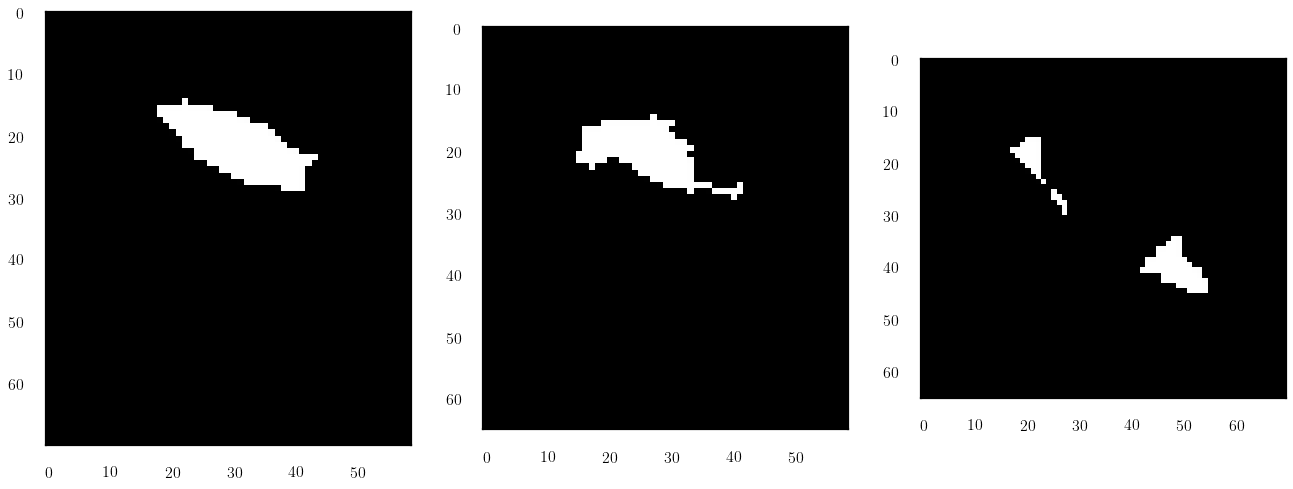

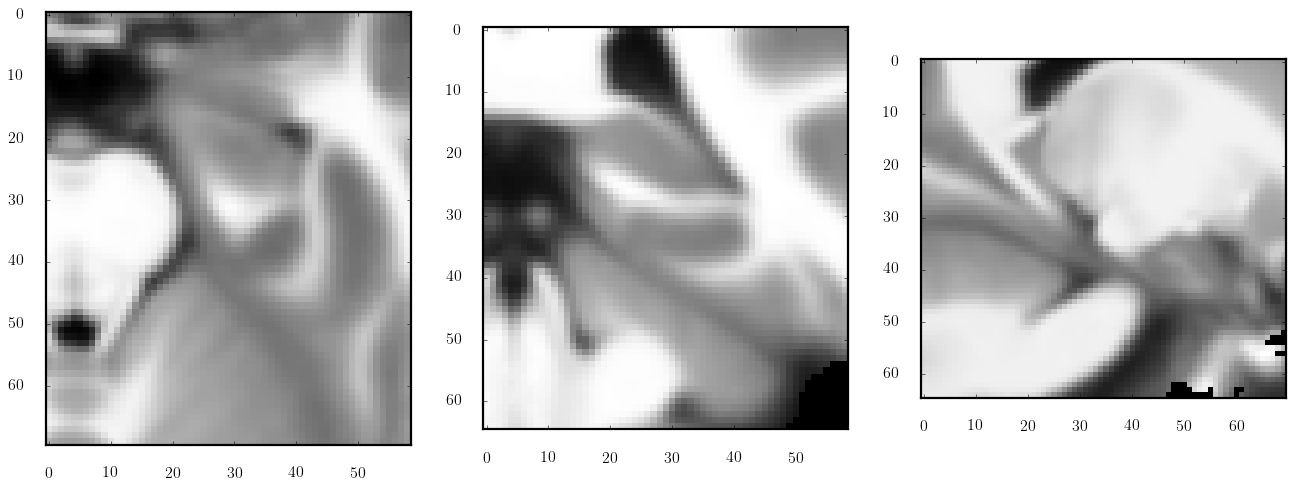

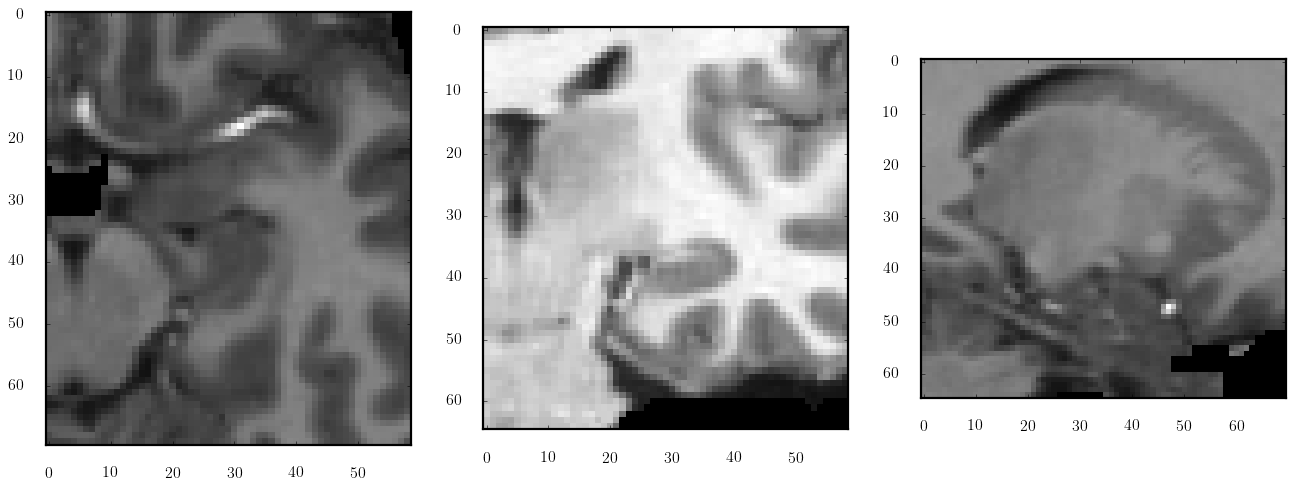

In [39]:
path = widgets.Text("../data/set_train/train_94.nii")
interact(
    show_alignment,
    input_file=path,
    i=widgets.IntSlider(min=0, max=50, step=1, value=20),
    j=widgets.IntSlider(min=0, max=50, step=1, value=20),
    k=widgets.IntSlider(min=0, max=50, step=1, value=20),
);